In [ ]:
# Install NetworkX if needed
# !pip install networkx

<div class="alert alert-block alert-success">
Notes on Utility

With only one bacteria, your only need 1 iteration
1 bacteria in iiFBA == FBA aka you only need one iteration

When you have one organism you will converge in one iteration, which is why is collapses to FBA

No need for time and rates because iterative convergence helps lead to the exact behavior we can expect in the first instance. 
^^ As long as growth is limited only by environmental flux and not internal constraints

If alpha zero, no insight to interaction unless there is cross-feeding, in which the consumer will consume after the first iteration
</div>

# Simple Models Implementation iiFBA


Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [1.]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [1.]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [0.5 0.5]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [0.5 0.5]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iterations set to: 10
Flow set to: 0.0
Relative abundances set to: [0.5 0.5]
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
I

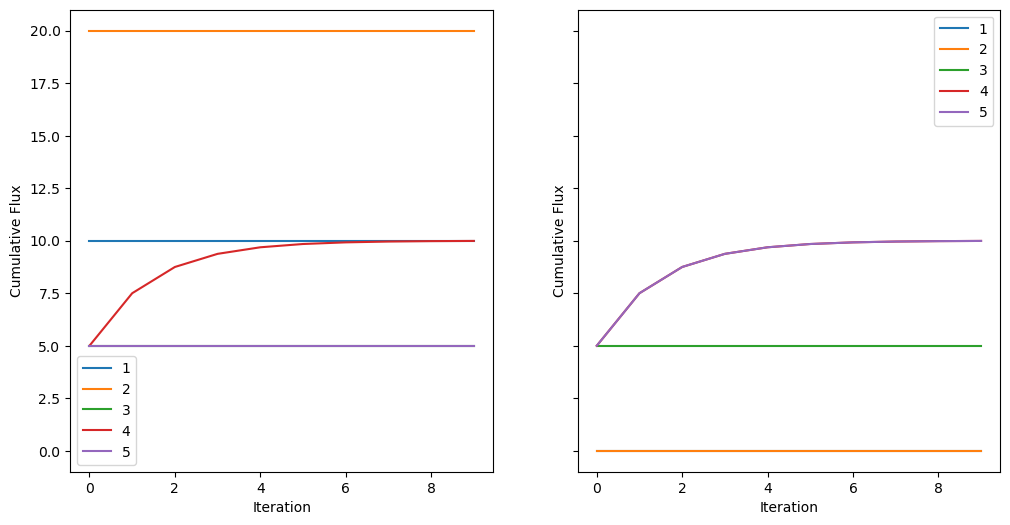

In [50]:
import iifba
from iifba.utils import load_simple_models
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
for sit_idx in range(1,6):
    models, media = load_simple_models(sit_idx)

    f, F = iifba.iipfba(models, media, rel_abund="equal", iters=10, flow=0) # defualt values

    biomass_id = "exchangeBio1"
    ax1 = iifba.iifba_vis(F.loc[0,:][biomass_id], ax=ax1, line_lab=sit_idx)
    if sit_idx > 2:
        biomass_id = "exchangeBio2"
        ax2 = iifba.iifba_vis(F.loc[1,:][biomass_id], ax=ax2, line_lab=sit_idx)
    else:
        ax2 = iifba.iifba_vis(np.zeros(10), ax=ax2, line_lab=sit_idx)
    

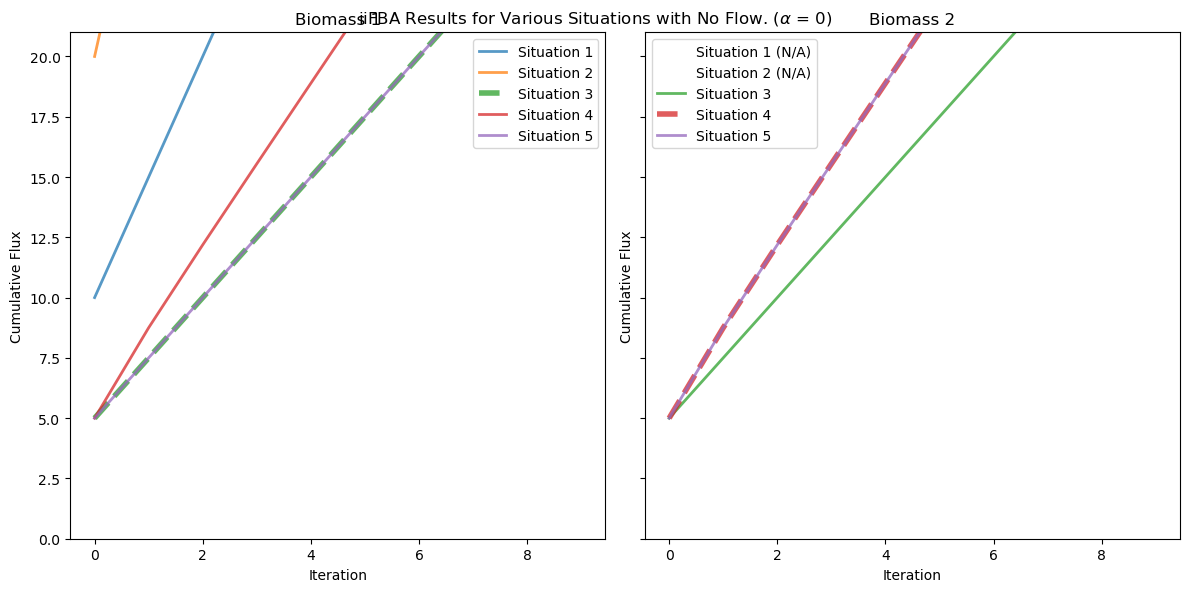

In [48]:
from IPython.display import display
for line in ax1.get_lines():
    line.set_alpha(0.75)  # Set transparency for all lines in ax1
    line.set_lw(2)
for line in ax2.get_lines():
    line.set_alpha(0.75)  # Set transparency for all lines in ax1
    line.set_lw(2)

ax1.get_lines()[2].set_lw(4)
ax2.get_lines()[3].set_lw(4)

ax1.get_lines()[2].set_ls("--")
ax2.get_lines()[3].set_ls("--")

ax2.get_lines()[0].set_lw(0)
ax2.get_lines()[1].set_lw(0)

# Update legends
ax1.legend(['Situation 1', 'Situation 2', 'Situation 3', 'Situation 4', 'Situation 5'])
ax2.legend(['Situation 1 (N/A)', 'Situation 2 (N/A)', 'Situation 3', 'Situation 4', 'Situation 5'])

# Method 3: Get and modify legend properties
legend1 = ax1.get_legend()
legend2 = ax2.get_legend()

# Use display() to show the updated plot
ax1.set_title("Biomass 1")
ax2.set_title("Biomass 2")

ax1.set_ylim(0, 21)

fig.tight_layout()
fig.suptitle(r"iiFBA Results for Various Situations with No Flow. ($\alpha$ = 0)")
display(fig)
# or alternatively, you can still use plt.show()
# plt.show()